In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torch import optim
from torchvision import utils
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed = 42
torch.manual_seed(seed=seed)
torch.set_float32_matmul_precision("high")

if device.type == 'cuda':
    torch.cuda.manual_seed_all(seed=seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

### Q.latent_dim이 작아지거나 커지면 어떻게 될까?
** 차원을 줄이는 경우 ** 

- latent_dim이 작아지면 잠재 공간에 인코딩할 수 있는 정보의 양이 줄어 원본 데이터의 중요한 특성들이 충분히 표현되지 못할 수 있으며, 결과적으로 디코더가 원본 데이터를 재구성하는 데 어려움을 겪게된다.
- 쉽게 말해 그릇이 작다보니 담고 싶은 정보들을 전부 다 담을 수 없게 되고 결국 손실되는 정보가 발생한다.

** 차원을 늘리는 경우 **

- latent_dim이 커지면 더 많은 정보가 잠재 공간에 저장될 수 있다. 즉, 원본 데이터의 특징을 더 잘 보존하게 되어 디코더가 원본 데이터와 유사한 데이터를 재구성하는 데 유리하다.
- 하지만 압축 효과가 줄어들어 오토인코더가 단순히 입력 데이터를 거의 그대로 통과시키는 현상이 발생할 수 있고, 이로 인해 오토인코더의 목적(데이터의 주요 특징을 추출하고 노이즈를 제거하는 것)이 약화될 수 있다.

In [3]:
epochs = 100
batch_size = 64
learning_rate = 0.001
latent_dim = 32

In [4]:
train_dataset = datasets.MNIST(root='/home/pervinco/Datasets/MNIST', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='/home/pervinco/Datasets/MNIST', train=False, transform=transforms.ToTensor(), download=True)

In [5]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

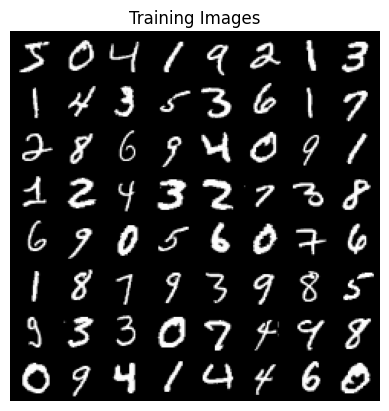

In [6]:
plt.axis('off')
plt.title("Training Images")
plt.imshow(np.transpose(utils.make_grid(torch.cat([train_dataset[i][0].unsqueeze(0) for i in range(64)], dim=0), normalize=True), (1,2,0)))

In [7]:
class Encoder(nn.Module):
    def __init__(self, latent_dim: int=20):
        super().__init__()

        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc_mean = nn.Linear(128, latent_dim)

    def forward(self, x: torch.Tensor):
        x = x.view(x.size(0), -1)
        x = F.leaky_relu(self.fc1(x), negative_slope=0.2)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.2)
        z = F.leaky_relu(self.fc_mean(x)) ## fc_mean은 prior distribution인 정규분포의 평균을 추정하는 것이 인코더의 목적임을 의미함.

        return z
    
class Decoder(nn.Module):
    def __init__(self, latent_dim: int=20):
        super().__init__()

        self.fc1 = nn.Linear(latent_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 784)

    def forward(self, z: torch.Tensor):
        z = F.leaky_relu(self.fc1(z), negative_slope=0.2)
        z = F.leaky_relu(self.fc2(z), negative_slope=0.2)

        x_hat = F.sigmoid(self.fc3(z)) ## Sigmoid 함수로 [0, 1]로 분포를 조절. --> gray scale 이미지니까.
        x_hat = x_hat.view(x_hat.size(0), 1, 28, 28) ## 원본 이미지와 같은 [28 X 28 X 1]의 형상으로 수정.

        return x_hat

In [8]:
class Autoencoder(nn.Module):
    def __init__(self, encoder=Encoder, decoder=Decoder, latent_dim: int=20):
        super().__init__()
        self.encoder = encoder(latent_dim=latent_dim)
        self.decoder = decoder(latent_dim=latent_dim)

        self.latent_dim = latent_dim

    def forward(self, x: torch.Tensor):
        z = self.encode(x)
        x_hat = self.decode(z)
        return z, x_hat

    def encode(self, x: torch.Tensor):
        return self.encoder(x)

    def decode(self, z: torch.Tensor):
        return self.decoder(z)

### Q.Reconstruction 작업시 MSE를 손실함수로 사용하는 이유?

- AutoEncoder는 이미지 압축 + 복원을 위한 모델. 이 때 압축으로 만들어진 latent vector를 Decoder에 입력시켜 원본으로 복원시킨 결과가 최초의 입력 이미지와 얼마나 같은지 정량적으로 비교할 수 있다.
- 즉, 정답이 있으므로 오차의 크기를 직접적으로 측정하는 Supervised Learning. 
- 오차의 제곱값이기 때문에, 예측값이 실제값과 얼마나 다른지에 대한 크기를 잘 반영할 수 있다. 오차가 클수록 그 영향이 크게 반영되며 작은 오차를 증폭시키기 때문에 무시하지 않고, 전반적으로 정확한 복원을 할 수 있도록 한다.
- 쉽게 말해 평균적 오류 최소화로 L1 처럼 특정 데이터 포인트에서의 오차보다, 전체적인 오차의 크기를 최소화하는 데 중점을 두는 것으로 해석할 수 있다.
- 참고로 최초의 입력은 Normalize되어 Discrete한 픽셀값이 Continuous한 값이 되기 때문에 BCE가 아닌 MSE를 사용할 수 있다.


### Q.Binary CrossEntropy를 손실 함수를 사용하면 어떻게 동작하나?

- BCE는 주로 이진 분류(binary classification) 문제에서 사용된다.
- 보통은 모델의 출력인 logit을 대상으로 threshold보다 높으면 1, 낮으면 0으로 이진 분류하는 형태.
- 반면 Reconstruction시 sigmoid로 0과 1사이 값으로 구성된 출력과 ToTensor의 적용에 따른 입력이 0과 1사이 값으로 정규화되기 때문에 BCE를 사용하더라도 문제가 없다.

주요한 차이점이라면 BCE는 ```확률```을 예측하기 위함이고 MSE는 분포의 ```평균, 분산```추정을 하는 것이 주요 목적이다.

In [9]:
autoencoder = Autoencoder(latent_dim=latent_dim).to(device)

recon_loss = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(params=list(autoencoder.parameters()), lr=learning_rate)

### Q.train_epoch_loss /= train_size로 왜 나누어 주는가?
- ```train_epoch_loss /= train_size``` 코드는 에포크 동안 계산된 평균 손실을 구하기 위해 사용한다. 
- 즉, 1epoch에서 발생한 n_step 손실들을 모두 더해 train_epoch_loss에 저장하고, 이를 1epoch에서 발생한 batch_size의 총합으로 나눠 1epoch의 평균 손실을 구하는 것.

### Q.train_size를 더해주는 것과 len(train_loader.dataset)의 차이점?
- train_size를 더해주는 것은 각 배치에서 label.size(0)을 더하는 방식으로 만약 train_loader에서 샘플을 불균형하게 가져오거나, 일부 배치가 누락될 경우에도 실제 학습된 샘플 수를 정확히 반영할 수 있다.
- len(train_loader.dataset)은 train_loader에 포함된 전체 데이터셋의 크기를 의미한다. 이는 데이터셋의 전체 크기를 고정적으로 반환하므로, 데이터 로딩 중에 샘플이 누락되거나 일부 데이터가 반복되지 않는다면 실제 학습에 사용된 샘플 수와 차이가 있을 수 있다.
- 결과적으로 1epoch의 평균 손실을 구할 때는 1epoch 동안 반영된 batch_x 또는 batch_y의 0번째 채널값을 모두 더하는 편이 안정적이라 할 수 있다.

In [10]:
history = dict(train_loss=[], valid_loss=[])

print(f"Training start with {epochs} epochs.")
for epoch in range(1, 1 + epochs):
    
    train_size = 0
    train_epoch_loss = 0
    autoencoder.train()
    for i, batch in enumerate(train_loader):
        image, label = batch
        image = image.to(device)

        train_size += label.size(0)
        latent = autoencoder.encode(image)
        reconstruction_image = autoencoder.decode(latent)

        optimizer.zero_grad()
        train_loss = recon_loss(image, reconstruction_image)
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss

    test_size = 0
    test_epoch_loss = 0
    autoencoder.eval()
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            image, label = batch
            image = image.to(device)
            test_size += label.size(0)

            latent = autoencoder.encode(image)
            reconstruction_image = autoencoder.decode(latent)

            test_loss = recon_loss(image, reconstruction_image)
            test_epoch_loss += test_loss

    train_epoch_loss /= train_size
    test_epoch_loss /= test_size

    history["train_loss"].append(train_epoch_loss.item())
    history["valid_loss"].append(test_epoch_loss.item())

    print(f"[{epoch:02d}/{epochs:02d}]"
        + f"Train MSE Loss = {train_epoch_loss:.4f}, "
        + f"Valid MSE Loss = {test_epoch_loss:.4f}")

Training start with 100 epochs.
[01/100]Train MSE Loss = 32.3404, Valid MSE Loss = 17.4214
[02/100]Train MSE Loss = 14.3855, Valid MSE Loss = 11.9061
[03/100]Train MSE Loss = 10.7549, Valid MSE Loss = 9.7543
[04/100]Train MSE Loss = 9.1190, Valid MSE Loss = 8.3640
[05/100]Train MSE Loss = 7.9431, Valid MSE Loss = 7.6735
[06/100]Train MSE Loss = 7.0871, Valid MSE Loss = 6.6435
[07/100]Train MSE Loss = 6.5404, Valid MSE Loss = 6.3393
[08/100]Train MSE Loss = 6.1950, Valid MSE Loss = 6.0967
[09/100]Train MSE Loss = 5.9392, Valid MSE Loss = 5.8456
[10/100]Train MSE Loss = 5.6798, Valid MSE Loss = 5.6004
[11/100]Train MSE Loss = 5.4481, Valid MSE Loss = 5.4509
[12/100]Train MSE Loss = 5.2654, Valid MSE Loss = 5.2329
[13/100]Train MSE Loss = 5.1194, Valid MSE Loss = 5.2532
[14/100]Train MSE Loss = 5.0101, Valid MSE Loss = 5.1889
[15/100]Train MSE Loss = 4.9152, Valid MSE Loss = 5.1093
[16/100]Train MSE Loss = 4.8327, Valid MSE Loss = 4.9983
[17/100]Train MSE Loss = 4.7577, Valid MSE Loss = 4

In [11]:
# 저장된 손실 함수를 시각화합니다.
def visualize_loss(epochs, train_loss, valid_loss):
    # x축 계산
    x_len = np.arange(epochs)

    plt.plot(x_len, train_loss, marker=".", c="blue", label="Train Loss")
    plt.plot(x_len, valid_loss, marker=".", c="red", label="Valid Loss")
    # 그래프에 대한 레이블 정보를 우측 상단에 출력합니다.
    plt.legend(loc='upper right')
    plt.grid()
    # x축과 y축에 대한 레이블을 설정합니다.
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

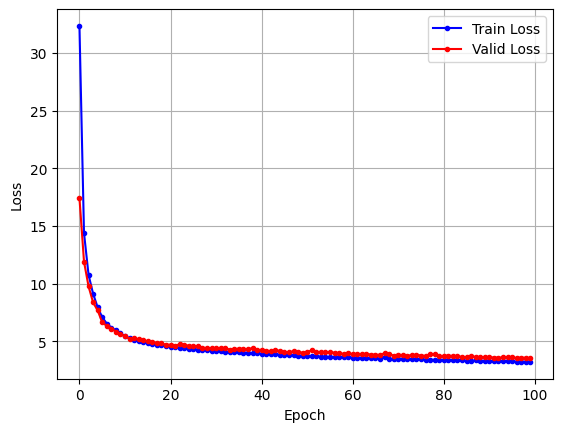

In [12]:
visualize_loss(epochs, history["train_loss"], history["valid_loss"])

In [13]:
select = 0
autoencoder.eval()
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        if i != select:
            continue
        else:
            test_image, test_label = batch
            test_image = test_image.to(device)
            test_image = test_image.view(batch_size, 1 * 28 * 28)

            z = autoencoder.encode(test_image)
            reconstruction = autoencoder.decode(z)
            break

데이터 배치의 첫 번째 이미지입니다.


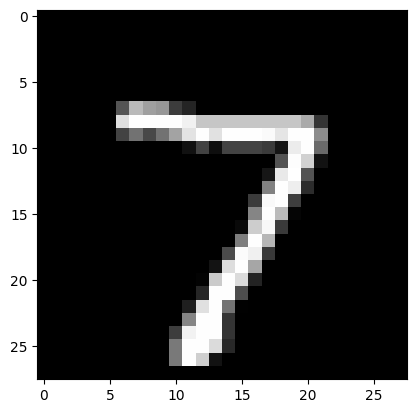

복원된 이미지입니다.


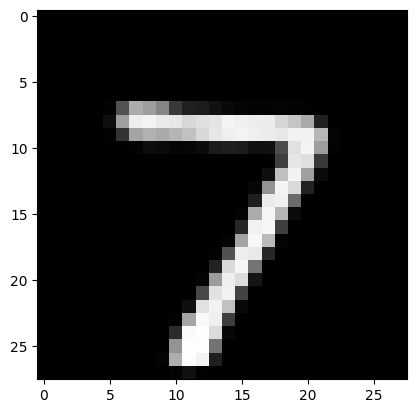

In [14]:
print("데이터 배치의 첫 번째 이미지입니다.")
plt.imshow(utils.make_grid(test_image[0].cpu().view(-1, 1, 28, 28)).permute(1, 2, 0))
plt.show()

print("복원된 이미지입니다.")
plt.imshow(utils.make_grid(reconstruction[0].cpu().view(-1, 1, 28, 28)).permute(1, 2, 0))
plt.show()

데이터 배치 이미지입니다.


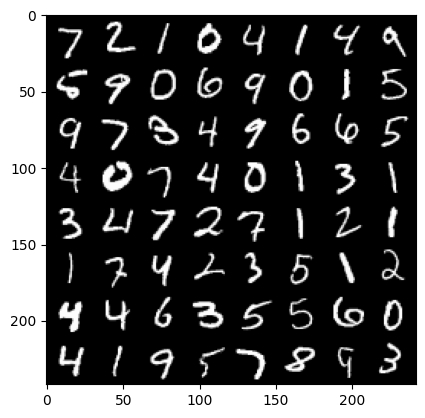

복원된 이미지입니다.


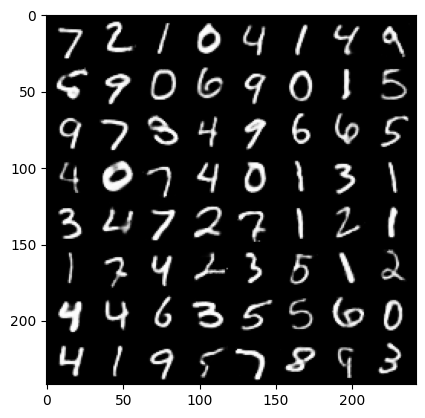

In [15]:
print("데이터 배치 이미지입니다.")
plt.imshow(utils.make_grid(test_image[:64].cpu().view(-1, 1, 28, 28)).permute(1, 2, 0))
plt.show()

print("복원된 이미지입니다.")
plt.imshow(utils.make_grid(reconstruction[:64].cpu()[:64].view(-1, 1, 28, 28)).permute(1, 2, 0))
plt.show()

## AutoEncoder의 잠재 벡터와 레이블을 이용한 T-SNE

In [18]:
from sklearn.manifold import TSNE

test_labels = []
test_latents = []
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        test_image, test_label = batch

        test_image = test_image.to(device)

        bs = test_image.size(0)
        test_image = test_image.view(bs, 784)

        z = autoencoder.encode(test_image)
        test_latents.append(z)
        test_labels.append(test_label)

test_latents = torch.cat(test_latents).cpu().numpy()
test_labels = torch.cat(test_labels).cpu().numpy()

tsne = TSNE(n_components=2).fit_transform(test_latents)

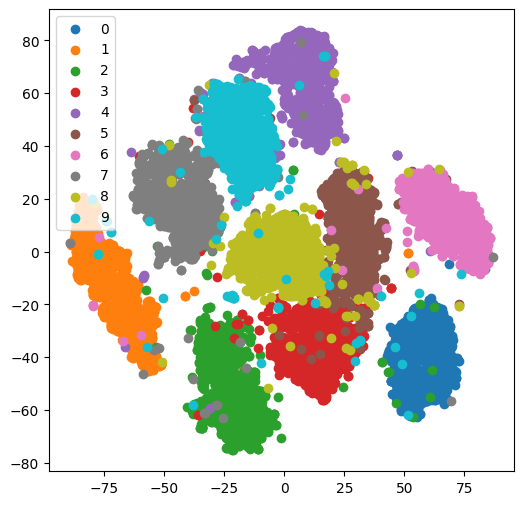

In [19]:
plt.figure(figsize=(6, 6))

target_ids = range(10)
colors = (
    'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
    'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
)

for i, c, label in zip(target_ids, colors, range(10)):
    plt.scatter(tsne[test_labels == i, 0], tsne[test_labels == i, 1], c=c, label=label)
plt.legend()
plt.show()

## 원본 이미지와 레이블을 이용한 T-SNE

In [22]:
test_images = []
test_labels = []

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        test_image, test_label = batch

        bs = test_image.size(0)
        test_image = test_image.view(bs, 784)

        test_images.append(test_image)
        test_labels.append(test_label)

test_images = torch.cat(test_images).cpu().numpy()
test_labels = torch.cat(test_labels).cpu().numpy()

tsne = TSNE(n_components=2).fit_transform(test_images)

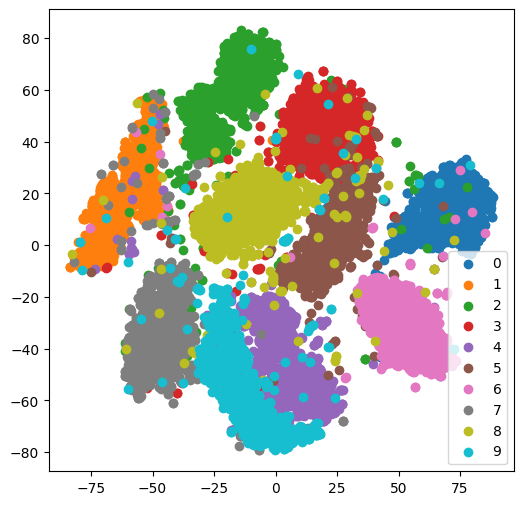

In [23]:
target_ids = range(10)

plt.figure(figsize=(6, 6))
colors = (
    'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
    'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
)

for i, c, label in zip(target_ids, colors, range(10)):
    plt.scatter(tsne[test_labels == i, 0], tsne[test_labels == i, 1], c=c, label=label)
plt.legend()
plt.show()